<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/Transformer/Transformer_code_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving 스크린샷 2021-03-10 오후 4.52.08.png to 스크린샷 2021-03-10 오후 4.52.08.png
User uploaded file "스크린샷 2021-03-10 오후 4.52.08.png" with length 85689 bytes


## 임포트

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install torchtext==0.4.0

     |████████████████████████████████| 61kB 8.0MB/s 
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0


In [49]:
import numpy as np
import torch
import torch.nn as nn
import torchtext
import spacy
from torchtext.data import Field,BucketIterator
import torch.optim as optim
from IPython.display import Image
import random
import time
import math

In [ ]:
input_text ="Forecasting still remains to be dominated by Statistical techniques like ARIMA, SARIMA, etc. due to their ease of use and interpretation, although there have been Neural Network competitors for a while based on RNN and LSTM, but they are still not as popular due to the complexity in setup hyperparameters tuning.".split()
vocab = set(input_text)
vocab_size = len(set(input_text))
embedding_size=8
w2i = {w:i for i,w in enumerate(set(input_text))}


In [ ]:
class embedding_process(nn.Module):
    def __init__(self,vocab_size,embedding_size):
        super(embedding_process,self).__init__()
        self.emb = nn.Embedding(vocab_size,embedding_size)

    def forward(self,x):
        
        return self.emb(x)

model = embedding_process(vocab_size,embedding_size)
model

embedding_process(
  (emb): Embedding(46, 8)
)

In [ ]:
tmp = torch.tensor([w2i["remains"]], dtype=torch.long)
tmp2 = torch.tensor([w2i["to"]], dtype=torch.long)

print(f"word 'remains': {model(tmp)}")
print(f"word 'to': {model(tmp2)}")

word 'remains': tensor([[-0.8297,  0.1399, -1.1149,  1.6015, -0.2312, -0.8998,  0.9542,  0.1350]],
       grad_fn=<EmbeddingBackward>)
word 'to': tensor([[-0.9708,  2.4837, -1.6940, -0.4985, -0.9618,  0.4150,  0.1195, -1.7402]],
       grad_fn=<EmbeddingBackward>)


## Positional Embedding  
  
- RNN은 각 state 마다 하나의 텍스트만을 받으면서 시퀀스 데이터를 처리할 수 있다. 가령 문장'나는 지금 일 중이다'를 RNN 모델에 입력할 때, RNN은 각 timestep 마다 분리된 각 단어를 해당 timestep의 state에 입력값으로 받는다: t1에 '나', t2에 '는', t3에 '지금' ...  
- 반면에, RNN에 의존하지 않는 Transformers 아키텍처는 이 시퀀스 데이터를 처리하기 위해, 조작적으로 RNN이 시퀀스 데이터를 입력받는 형태와 같은 변환이 요구된다. 여기서 사용되는 것이 Positional Encoding 이다.  
  
아래는 포지셔널 인코딩의 메커니즘에 대한 도해이다.

In [ ]:
Image('/content/스크린샷 2021-03-10 오후 1.47.27.png',width=900,height=600)

## 인코더와 디코더

인코더의 **마지막 레이어 출력값**이 디코더의 **모든 레이어**에 입력된다.  
- 이때, 디코더 파트의 단어가 쿼리 역할을 하고, 인코더 파트의 단어들이 키 역할을 한다.

그림 출처: 동빈나 유튜브

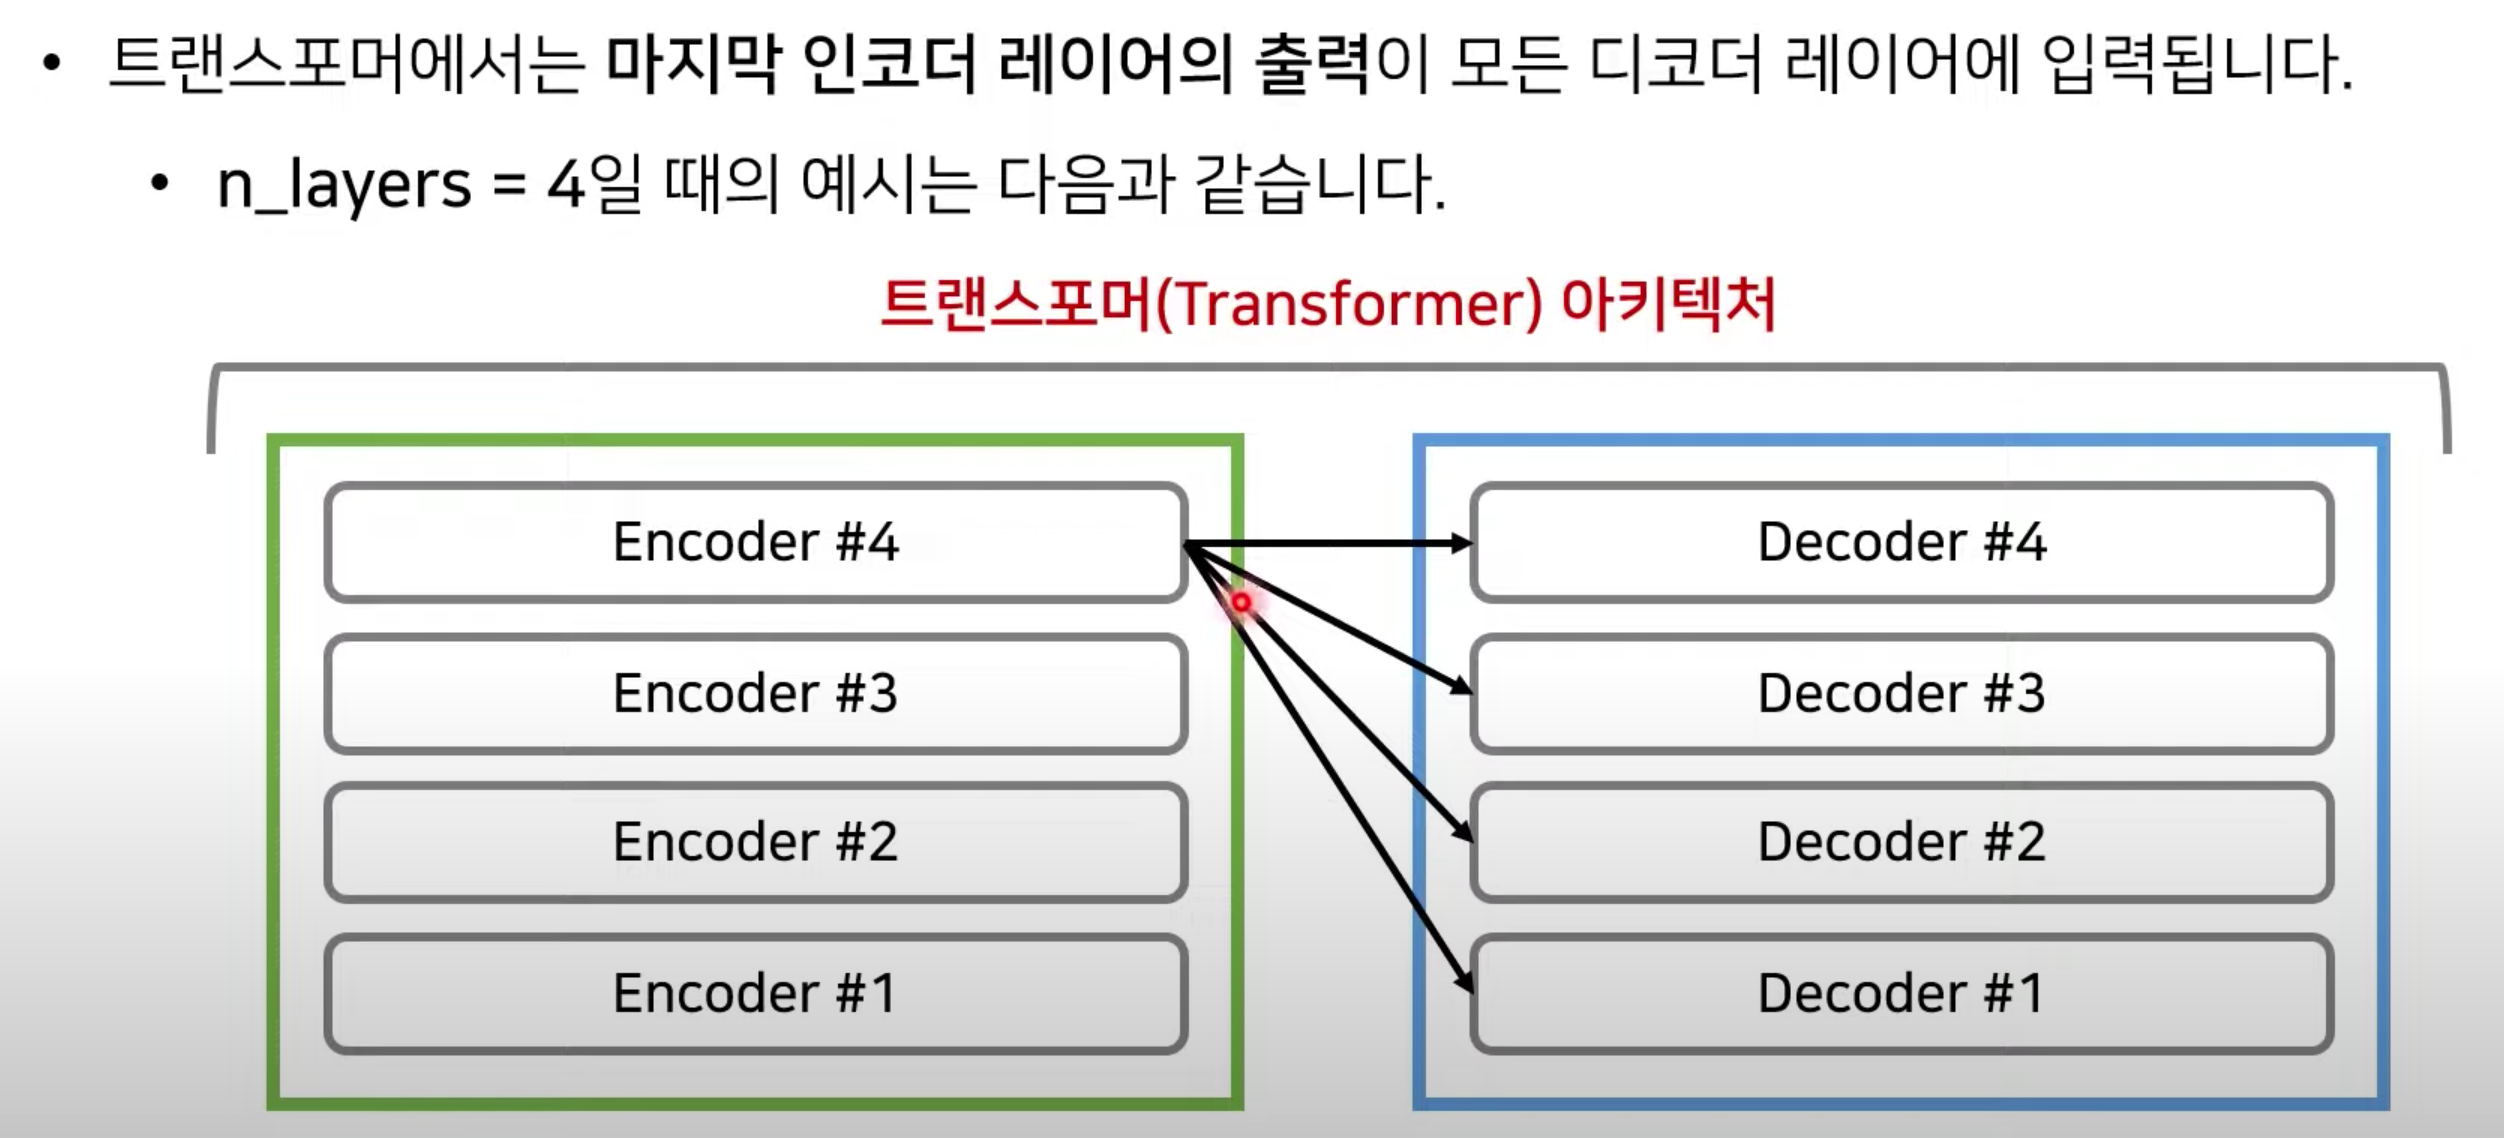

In [ ]:
Image('/content/스크린샷 2021-03-10 오후 1.57.00.png',width=500)

## 셀프 어텐션

### 왜 셀프어텐션을 사용하는가  
  
- 레이어 당 계산 복잡도 감소  
  - 기존의 RNN, CNN 보다 작은 복잡도를 가진다: $O(n^2,d)$  
- RNN과 다르게 병렬화된 연산 가능  
- 길이가 긴 입력값에 대해서도 잘 학습할 수 있다  
- 해석 가능성 증가  

  - 시각화를 통하여 어느 부분에서 얼만큼의 가중치를 얻었는지 알 수 있다.

설명 참고: [유튜브 nlp-masters] https://www.youtube.com/watch?v=dTf-ALfbC8Q

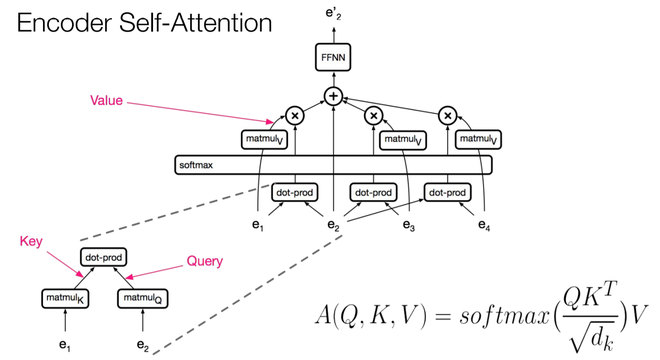

In [ ]:
Image('/content/encoderselfattention-660x360.png',width=600)

In [ ]:
sample1 = torch.tensor([1,2,3,4,5,6,7,8,9])
sample2 = torch.tensor(np.random.rand(9))
sample3 = torch.tensor(np.random.rand(9))
dk = 10000

v1 = sample1[6:9]
v2 = sample2[6:9]
v3 = sample3[6:9]

def sampler (sample):
    q = sample[0:3]
    k = sample[3:6]
    v = sample[6:9]
    return q,k,v


def softmax(ls):
    ress = []
    for ak in ls:
        

        den = torch.exp(ak)
        nom = torch.sum(torch.exp(ls))
        res= den/nom
        ress.append(res)

    return torch.tensor(ress)


mat1 = torch.matmul(sampler(sample1)[0],sampler(sample1)[1])
mat2 = torch.matmul(sampler(sample2)[0],sampler(sample2)[1])
mat3 = torch.matmul(sampler(sample3)[0],sampler(sample3)[1])

scaled1 = mat1 / dk
scaled2 = mat2 / dk
scaled3 = mat3 / dk

scaled_list = torch.Tensor([scaled1,scaled2,scaled3])

softmax_res = softmax(scaled_list)

mul1 = torch.mul(softmax_res,v1)
mul2 = torch.mul(softmax_res,v2)
mul3 = torch.mul(softmax_res,v3)


attention_score = mul1+mul2+mul3
print(attention_score)

tensor([2.7420, 3.1557, 3.1300], dtype=torch.float64)


## 실습  
  
동빈나 유튜브 참고 및 발췌

### args

In [95]:
import argparse

parser = argparse.ArgumentParser(description= 'hyper-parameters')
args = parser.parse_args("")

args.EPOCHS=10
args.BATCH_SIZE= 128
args.LR = 0.0005
args.HIDDEN_DIM = 256
args.N_HEADS = 8
args.DROPOUT_RATE=0.3
args.ENC_LAYERS=3
args.DEC_LAYERS=3
args.ENC_HEADS=8
args.DEC_HEADS=8
args.ENC_PF_DIM = 512
args.DEC_PF_DIM = 512
args.ENC_DROPOUT = 0.1
args.DEC_DROPOUT = 0.1
args.clip=1

### 데이터 로드 및 전처리

In [4]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [5]:
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

In [6]:
def tok_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

def tok_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [7]:
src = Field(tokenize=tok_de,init_token="<sos>",eos_token="<eos>",lower=True,batch_first=True)
tgt = Field(tokenize=tok_en,init_token="<sos>",eos_token="<eos>",lower=True,batch_first=True)

### Load dataset for training

In [8]:
from torchtext.datasets import Multi30k

trainset,valset,testset = Multi30k.splits(exts=(".de",".en"),fields=(src,tgt))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 1.02MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 274kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 265kB/s]


In [9]:
print(len(trainset.examples))
print(len(valset.examples))
print(len(testset.examples))

29000
1014
1000


#### Vocab 사전 구축  
- 초기 input_dimension 구하기 위해

In [10]:
src.build_vocab(trainset,min_freq=2)
tgt.build_vocab(trainset,min_freq=2)
print(len(src.vocab))
print(len(tgt.vocab))

7855
5893


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter,val_iter,test_iter = BucketIterator.splits((trainset,valset,testset),batch_size = args.BATCH_SIZE,device=device)

이터레이터 확인

In [ ]:
# for i,b in enumerate(train_iter):
#     src=b.src
#     tgt=b.trg

#     print(f'1st batch shape: {src.shape}')

#     for i in range(src.shape[1]):
#         print(f'index: {i}:{src[0][i].item()}')

## 모델

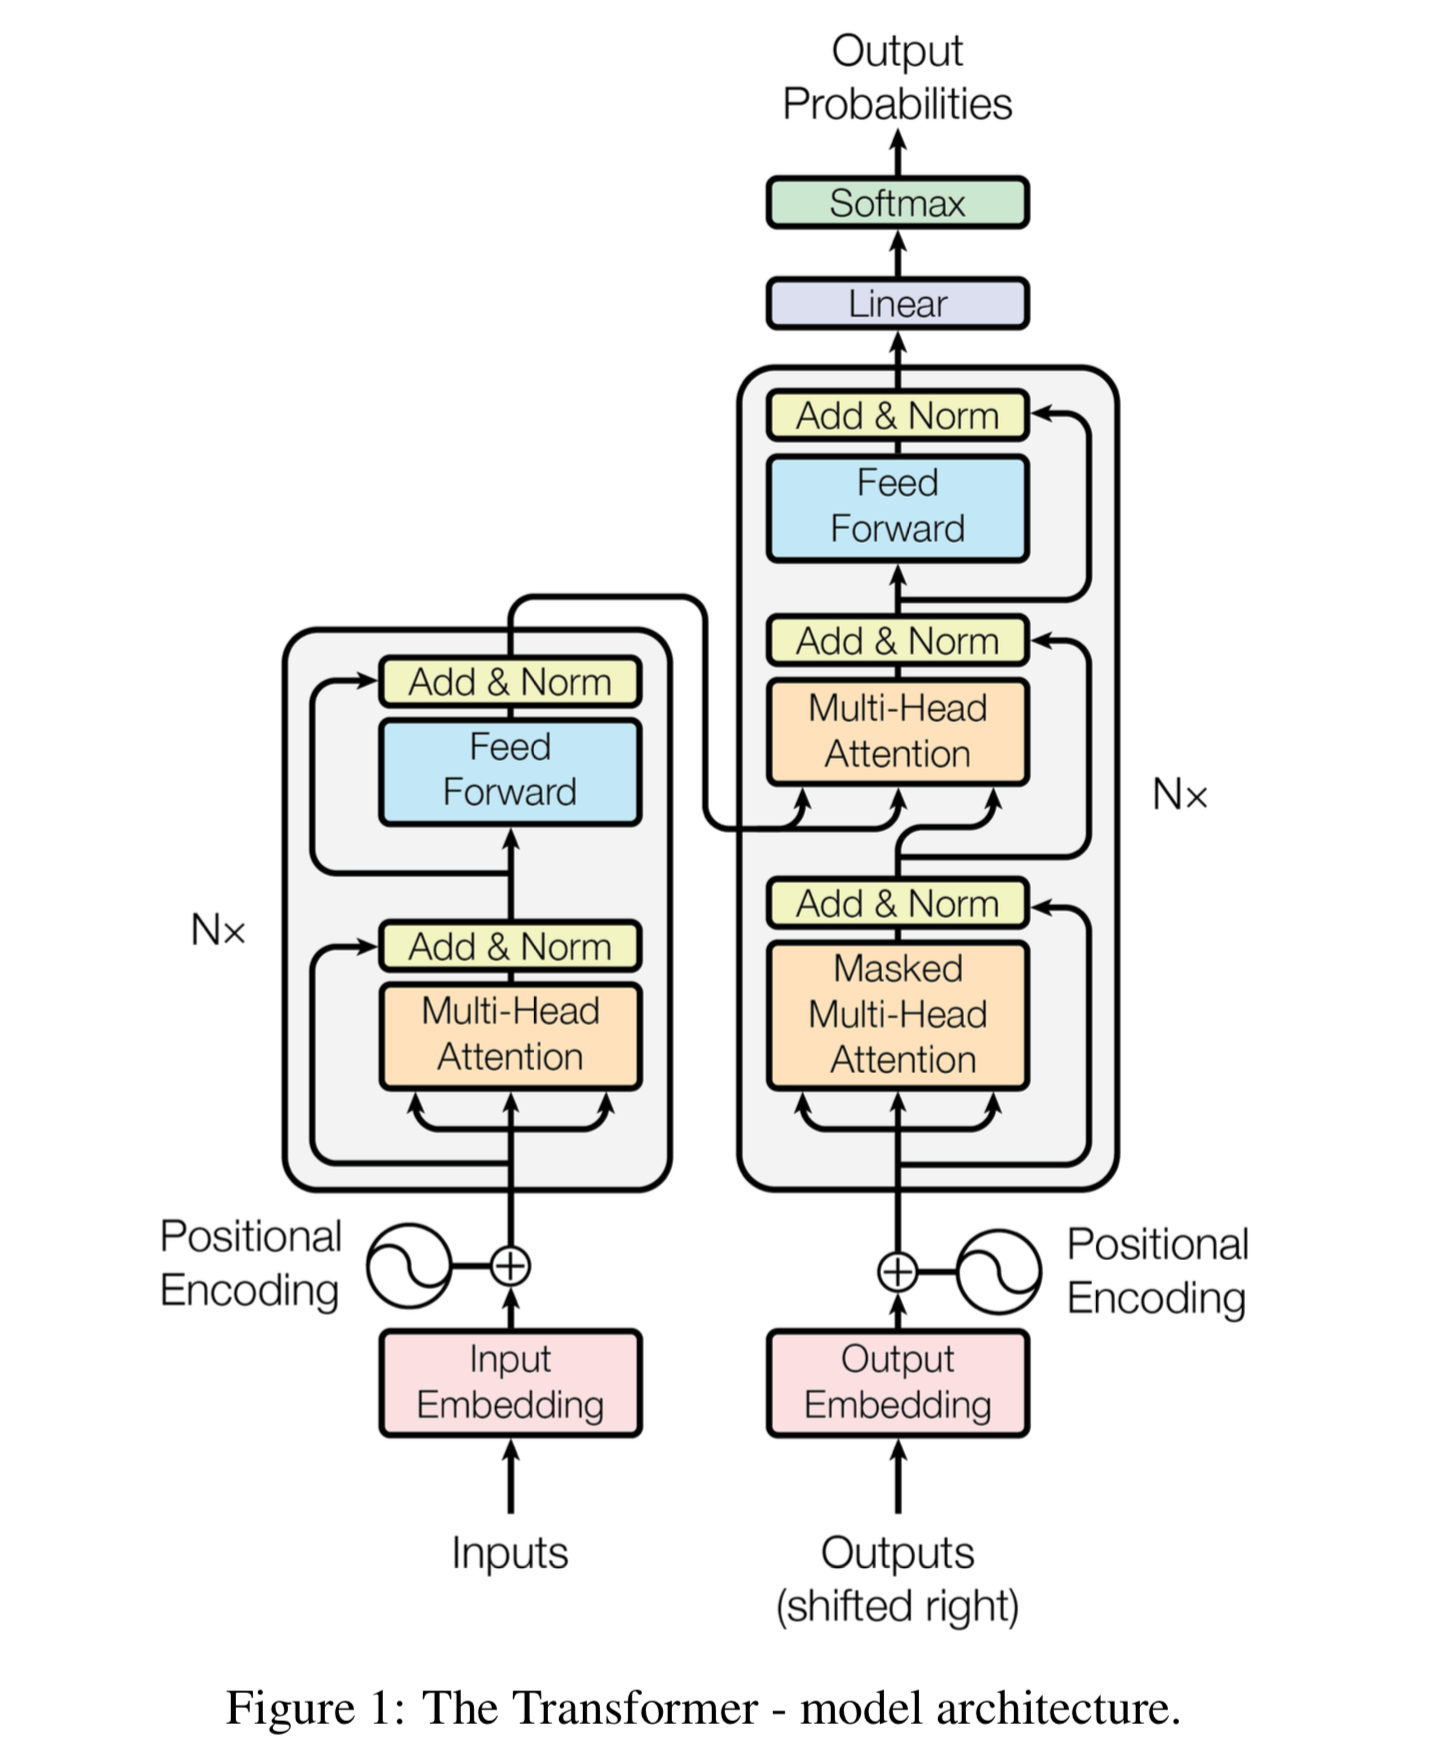

In [ ]:
Image('/content/1_BHzGVskWGS_3jEcYYi6miQ.png',width=600)

### MultiHead Attention Layer

In [12]:
class MultiHead_Attention_Layer(nn.Module):
    def __init__(self,hidden_dim,n_heads,dropout_rate,device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads # 각 헤드에 포함되어 있는 임베딩 차원
    
        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # 선형 변환일 뿐
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_rate)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)


    def forward(self, query, key, value, mask=None):
        
        batch_size = query.shape[0] # 위에서 맨 앞에 batch_first를 두었음
        """
        query: [batch_size, query_len, hidden_size]
        key
        value
        """
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # hidden_size --> n_heads, head_dim 으로 변형
        Q= Q.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3) # .permute()에 의해, Q:[batch_size, n_heads, query_len, head_dim] 으로 변경
        K= K.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
        V= V.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)

        # energy: [batch_size, n_heads, query_len, key_len]
        energy = torch.matmul(Q,K.permute(0,1,3,2)) / self.scale # K.permute :[batch_size, n_heads, head_dim, query_len] --> K를 이렇게 바꿈으로써 matmul이 가능해짐.

        if mask is not None:
            energy = energy.masked_fill(mask==0,-1e10) # 마스크 0인 부분에 - lemnicate 가까운 값을 넣어줌

        attention = torch.softmax(energy, dim=-1) #[batch_size, n_heads, query_len, key_len]

        x = torch.matmul(self.dropout(attention),V) # x: [batch_size, n_heads, query_len, head_dim]
        
        #x: [batch_size, query_len, n_heads, head_dim]
        x = x.permute(0,2,1,3).contiguous() # 일반적으로 당신은 이것에 대해 걱정할 필요가 없습니다. RuntimeError : input is not contiguous가 나타나면 contiguous()에 대한 호출을 추가합니다.
        
        x = x.view(batch_size, -1, self.hidden_dim) # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        return x, attention
        

### Position-wise FeedFoward

- pf_dim: ff 안에서 내부 임베딩 차원

In [13]:
class Postionwise_FeedForward_Layer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_rate):
        super().__init__()
        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim,hidden_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # [batch_size, seq_len, hidden_dim] --> # [batch_size, seq_len, pf_dim]
        x = self.dropout(torch.relu(self.fc_1(x))) 
        x = self.fc_2(x)

        return x

### 인코더 레이어
- 위에서 만든 멀티헤드어텐션 레이어와 포지션왕이드 피드포워드 모두를 사용  
- 입출력 차원 *동일*

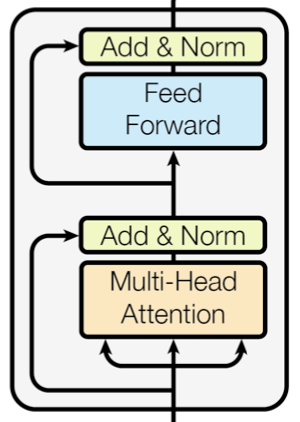

In [ ]:
Image('/content/스크린샷 2021-03-10 오후 4.18.14.png',width=300)

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self,hidden_dim,n_heads,pf_dim,dropout_rate,device):
        super().__init__()

        self.self_attention = MultiHead_Attention_Layer(hidden_dim, n_heads, dropout_rate, device)
        self.postionwise_feedforward = Postionwise_FeedForward_Layer(hidden_dim, pf_dim, dropout_rate)

        self.self_attention_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src, src_mask):
        #src: [batch_size, src_len, hid_dim]
        #src_mask: [batch_size, src_len]

        _src, _ = self.self_attention(src,src,src,src_mask) # 동일한 src를 q,k,v 로 출력하기 위해 복제해서 넣어줌.
        src = self.self_attention_layer_norm(src + self.dropout(_src)) # 잔차 연결과 norm
        
        _src = self.postionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src)) # [batch_size, src_len,hidden_dim]

        return src

## 전체 인코더  
- pad는 토큰에 대해 마스크 값을 0으로 설정  
- 위에서 만든 EncoderLayer를 N개 사용

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_rate, device, max_length=100):
        super().__init__()

        self.device = device
        self.tok_emb = nn.Embedding(input_dim, hidden_dim)
        self.pos_emb = nn.Embedding(max_length, hidden_dim) # 위치에 대한 정보값을 넣어주기 우이해 별도의 pos_emb 를 넣어줌
        
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_rate, device) for _ in range(n_layers)]) # Encoder Layer를 중첩 사용하기 때문에 n_layers 만큼 스택해줌

        self.dropout = nn.Dropout(dropout_rate)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self,src,src_mask):
        #src, src_mask: [batch_size,src_len]
        batch_size = src.shape[0]
        src_len = src.shape[1] # 각 문장 중 단어 개수가 가장 많은 문장의 개수

        #pos: [batch_size, src_len]
        pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device) # 각 문장마다 위치 정보를 넣어주기 위해 repeat 수행
        #src: [batch_size, src_len, hidden_dim]
        src = self.dropout((self.tok_emb(src)*self.scale) + self.pos_emb(pos)) # 입력값 tok_emb에 위치 정보가 담긴 pos_emb를 더해줘
        
        for layer in self.layers:
            src = layer(src,src_mask) # src: [batch_size, src_len, hid_dim]

        return src


### 디코더 레이어  
- 소스 문장의 pad 토큰의 마스크 값을 0 으로 설정  
- 타겟 문장에서 각 단어는 다음 단어가 무엇읹지 알 수 없도록 함. (mask 사용)

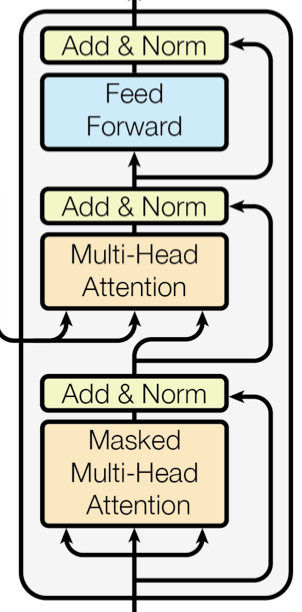

In [ ]:
Image('/content/스크린샷 2021-03-10 오후 4.52.08.png',width=300)

In [80]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_rate, device):
        super().__init__()

        self.self_attention_layer = MultiHead_Attention_Layer(hidden_dim, n_heads, dropout_rate, device)
        self.positionwise_feedforward = Postionwise_FeedForward_Layer(hidden_dim, pf_dim, dropout_rate)
        self.encoder_attention = MultiHead_Attention_Layer(hidden_dim, n_heads, dropout_rate, device)

        self.self_attention_layer_norm = nn.LayerNorm(hidden_dim)
        self.encoder_attention_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg: [batch, trg_len, hiddim]
        # enc_src : [btc, srclen, hiddim]
        # src_mask, trg_mask : [btc, trg_len] 
 
        _trg, _ = self.self_attention_layer(trg,trg,trg,trg_mask) # [1] decoder attention 수행
        
        trg = self.self_attention_layer_norm(trg+self.dropout(_trg)) # [batch_size, trg_len, hid_dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask) # [2] 인코더에서 정보 가져옴. enc-dec attention 수행
        """
        여기서 주목할 점은, query 로서 trg의 단어가 사용되었고, 그것의 key,value로서 enc_src에서 전달된 정보를 사용했다는 것이다.
        """
        
        trg = self.encoder_attention_norm(trg+self.dropout(_trg))

        _trg = self.positionwise_feedforward(trg)

        trg = self.ff_layer_norm(trg+self.dropout(_trg)) 
        
        # trg: [batch_size, trg_len, hidden]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention
        

### 전체 디코더

In [81]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_rate, device, max_length=100):
        super().__init__()

        self.device = device
        self.tok_emb = nn.Embedding(output_dim, hidden_dim)
        self.pos_emb = nn.Embedding(max_length, hidden_dim) # 위치에 대한 정보값을 넣어주기 우이해 별도의 pos_emb 를 넣어줌
        
        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_rate, device) for _ in range(n_layers)]) # Encoder Layer를 중첩 사용하기 때문에 n_layers 만큼 스택해줌

        self.fc_out = nn.Linear(hidden_dim,output_dim)

        self.dropout = nn.Dropout(dropout_rate)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, tgt, enc_src, tgt_mask, src_mask):
        
        #tgt:[batch_size,tgt_len]
        #enc_src: [batch_size,src_len,hidden_dim]
        #src, src_mask: [batch_size,src_len]

        batch_size = tgt.shape[0]

        tgt_len = tgt.shape[1] # 각 문장 중 단어 개수가 가장 많은 문장의 개수

        #pos: [batch_size, src_len]
        pos = torch.arange(0,tgt_len).unsqueeze(0).repeat(batch_size,1).to(self.device) # 각 문장마다 위치 정보를 넣어주기 위해 repeat 수행
        #tgt: [batch_size, tgt_len, hidden_dim]
        tgt = self.dropout((self.tok_emb(tgt)*self.scale) + self.pos_emb(pos)) # 입력값 tok_emb에 위치 정보가 담긴 pos_emb를 더해줘
        
        for layer in self.layers:
            tgt, attention = layer(tgt,enc_src,tgt_mask,src_mask) 
            # tgt: [batch_size, src_len, hid_dim]
            # attention: [batch_size,n_heads,tgt_len,src_len]

        output = self.fc_out(tgt)

        return output, attention

## 트랜스포머

#### 아래 테크닉 예습

In [21]:
a = torch.tensor([1,2,3,4])
b= torch.tensor([1,1,3,3])

print((a!=b).unsqueeze(1).unsqueeze(2))

tensor([[[False]],

        [[ True]],

        [[False]],

        [[ True]]])


- torch.tril:  
Returns the lower triangular part of the matrix (2-D tensor) or batch of matrices input, the other elements of the result tensor out are set to 0.

In [71]:
a = torch.tensor([[1,2,3,],[4,3,2],[2,1,1]])
print(a,'\n')
print(torch.tril(a),'\n')
print(torch.tril(a).bool(),'\n')
print(a & torch.tril(a).bool())

tensor([[1, 2, 3],
        [4, 3, 2],
        [2, 1, 1]]) 

tensor([[1, 0, 0],
        [4, 3, 0],
        [2, 1, 1]]) 

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]]) 

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 1]])


In [90]:
class Transformer(nn.Module):
    def __init__(self,encoder,decoder,src_pad_idx,tgt_pad_idx,device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.device = device

    #소스 문장 <pad> 토큰의 마스크 값을 0으로 설정
    def make_src_mask(self,src):
        """
        100
        110
        110
        """
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # [batch_size,src_len --> batch_size,1,1,src_len]
        return src_mask

    #타겟 문장에선 각 단어의 다음 단어를 가리도록 마스크 사용
    def make_tgt_mask(self,tgt):
        """
        100
        110
        111
        """
        tgt_pad_mask = (tgt!=self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)# [batch_size,tgt_len --> batch_size,1,1,tgt_len]
        
        tgt_len = tgt.shape[1]
        tgt_sub_mask = torch.tril(torch.ones((tgt_len,tgt_len),device=self.device)).bool() # [trg_len, trg_len]

        tgt_mask = tgt_pad_mask & tgt_sub_mask # 둘다에서 1의 값을 가리는 곳에서만 어텐션 스코어를 구하게 함

        return tgt_mask

    def forward(self,src,tgt):
        
        src_mask = self.make_src_mask(src) # [bc, src_len] -> [bc,1,1,src_len]
        tgt_mask = self.make_tgt_mask(tgt) # [bc,tgt_len] -> [bc,1,tgt_len,tgt_len]

        enc_src = self.encoder(src, src_mask) # bc, src_len, hid_dim
        output, attention =self.decoder(tgt,enc_src,tgt_mask,src_mask) # output: bc,tgt_len,out_dim
                                                                       # attn: bc, n_heads, tgt_len, src_len

        return output, attention


## 학습

In [94]:
INPUT_DIM = len(src.vocab)
OUTPUT_DIM = len(tgt.vocab)

SRC_PAD_IDX = src.vocab.stoi[src.pad_token]
TGT_PAD_IDX = tgt.vocab.stoi[tgt.pad_token]

enc = Encoder(INPUT_DIM,args.HIDDEN_DIM,args.ENC_LAYERS,args.ENC_HEADS,args.ENC_PF_DIM,args.ENC_DROPOUT,device)
dec = Decoder(OUTPUT_DIM,args.HIDDEN_DIM,args.DEC_LAYERS,args.DEC_HEADS,args.DEC_PF_DIM,args.DEC_DROPOUT,device)

model = Transformer(enc,dec,SRC_PAD_IDX, TGT_PAD_IDX, device).to(device)

In [84]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'파라미터 개수: {count_param(model)}')

파라미터 개수: 3934085


#### 모델 가중치 파라미터 초기화

In [85]:
def initialize_weights(m):
    if hasattr(m,'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_emb): Embedding(7855, 128)
    (pos_emb): Embedding(100, 128)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attention): MultiHead_Attention_Layer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (postionwise_feedforward): Postionwise_FeedForward_Layer(
          (fc_1): Linear(in_features=128, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (self_attention_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      

### Trainig start

In [101]:
def epoch_time(start_time,end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    
    return elapsed_mins, elapsed_secs

In [97]:
optimizer = optim.Adam(model.parameters(), lr= args.LR)
criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)

def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)
         

In [98]:

# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [103]:
best_valid_loss = float('inf')

for epoch in range(args.EPOCHS):


    start =time.time()

    train_loss = train(model, train_iter, optimizer, criterion, args.clip)
    valid_loss = evaluate(model, val_iter,criterion)

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start,end)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/models/transformers ger-eng/transformer.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 12s
	Train Loss: 2.836 | Train PPL: 17.049
	Validation Loss: 2.563 | Validation PPL: 12.979
Epoch: 02 | Time: 0m 12s
	Train Loss: 2.640 | Train PPL: 14.015
	Validation Loss: 2.411 | Validation PPL: 11.147
Epoch: 03 | Time: 0m 12s
	Train Loss: 2.482 | Train PPL: 11.970
	Validation Loss: 2.304 | Validation PPL: 10.012
Epoch: 04 | Time: 0m 12s
	Train Loss: 2.347 | Train PPL: 10.450
	Validation Loss: 2.205 | Validation PPL: 9.070
Epoch: 05 | Time: 0m 12s
	Train Loss: 2.232 | Train PPL: 9.316
	Validation Loss: 2.133 | Validation PPL: 8.440
Epoch: 06 | Time: 0m 12s
	Train Loss: 2.128 | Train PPL: 8.399
	Validation Loss: 2.084 | Validation PPL: 8.039
Epoch: 07 | Time: 0m 12s
	Train Loss: 2.038 | Train PPL: 7.677
	Validation Loss: 2.027 | Validation PPL: 7.589
Epoch: 08 | Time: 0m 12s
	Train Loss: 1.956 | Train PPL: 7.070
	Validation Loss: 1.974 | Validation PPL: 7.197
Epoch: 09 | Time: 0m 12s
	Train Loss: 1.882 | Train PPL: 6.567
	Validation Loss: 1.953 | Validation PPL: 

In [105]:
from google.colab import files

files.download('/content/drive/MyDrive/models/transformers ger-eng/transformer.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 모델 테스트

In [107]:
path='/content/drive/MyDrive/models/transformers ger-eng/transformer.pt'
model.load_state_dict(torch.load(path))

test_loss = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.939 | Test PPL: 6.949
